<a href="https://colab.research.google.com/github/vaibhatt/Fall_Fest_iNets/blob/main/covid_image_segmentation_accuracy_99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/drive/MyDrive/covid_imgseg.zip

Archive:  /content/drive/MyDrive/covid_imgseg.zip
   creating: covid_imgseg/
   creating: covid_imgseg/ct_scans/
  inflating: covid_imgseg/ct_scans/coronacases_org_001.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_002.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_003.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_004.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_005.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_006.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_007.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_008.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_009.nii  
  inflating: covid_imgseg/ct_scans/coronacases_org_010.nii  
  inflating: covid_imgseg/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: covid_imgseg/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: covid_imgseg/ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  in

In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
import cv2
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [3]:
raw_data = pd.read_csv('/content/covid_imgseg/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/' , '/content/covid_imgseg/', regex = True) 
raw_data.head(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/covid_imgseg/ct_scans/coronacases_org...,/content/covid_imgseg/lung_mask/coronacases_00...,/content/covid_imgseg/infection_mask/coronacas...,/content/covid_imgseg/lung_and_infection_mask/...
1,/content/covid_imgseg/ct_scans/coronacases_org...,/content/covid_imgseg/lung_mask/coronacases_00...,/content/covid_imgseg/infection_mask/coronacas...,/content/covid_imgseg/lung_and_infection_mask/...
2,/content/covid_imgseg/ct_scans/coronacases_org...,/content/covid_imgseg/lung_mask/coronacases_00...,/content/covid_imgseg/infection_mask/coronacas...,/content/covid_imgseg/lung_and_infection_mask/...
3,/content/covid_imgseg/ct_scans/coronacases_org...,/content/covid_imgseg/lung_mask/coronacases_00...,/content/covid_imgseg/infection_mask/coronacas...,/content/covid_imgseg/lung_and_infection_mask/...
4,/content/covid_imgseg/ct_scans/coronacases_org...,/content/covid_imgseg/lung_mask/coronacases_00...,/content/covid_imgseg/infection_mask/coronacas...,/content/covid_imgseg/lung_and_infection_mask/...


In [4]:
raw_data.shape

(20, 4)

In [5]:
# to read nii files and return arrays

def reader(filepath):
    input = nib.load(filepath)
    return(np.rot90(np.array(input.get_fdata())))

In [6]:
#taking few samples for viewing

ctscan_image = reader(raw_data.loc[1,'ct_scan'])
lung_mask_image = reader(raw_data.loc[1, 'lung_mask'])
infection_mask_image = reader(raw_data.loc[1, 'infection_mask'])
lung_infection_mask_image = reader(raw_data.loc[1, 'lung_and_infection_mask'])

Text(0.5, 1.0, 'Lung and Infection Mask')

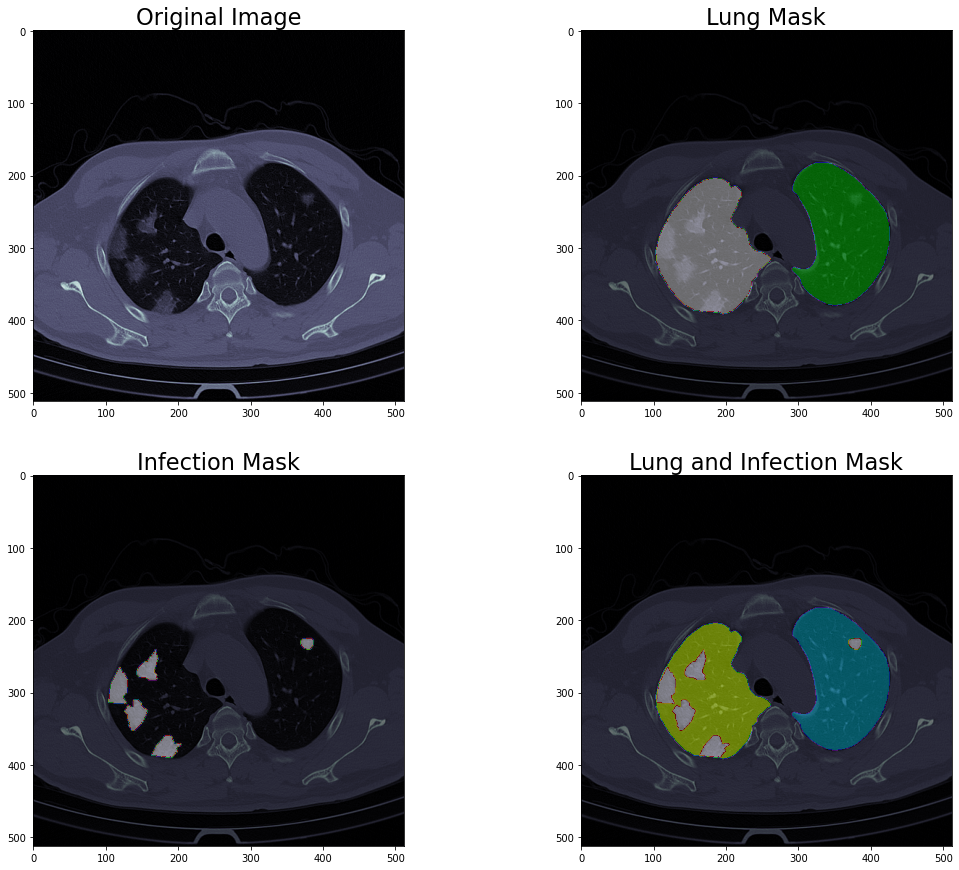

In [7]:
# viewing.....

fig = plt.figure(figsize = (18, 15))
plt.subplot(2, 2, 1)
plt.imshow(ctscan_image[..., 150], cmap = 'bone')
plt.title('Original Image', fontsize = 22.5)

plt.subplot(2, 2, 2)
plt.imshow(ctscan_image[..., 150], cmap = 'bone')
plt.imshow(lung_mask_image[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask', fontsize = 22.5)

plt.subplot(2, 2, 3)
plt.imshow(ctscan_image[..., 150], cmap = 'bone')
plt.imshow(infection_mask_image[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask', fontsize = 22.5)

plt.subplot(2, 2, 4)
plt.imshow(ctscan_image[..., 150], cmap = 'bone')
plt.imshow(lung_infection_mask_image[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask', fontsize = 22.5)

In [8]:
# piling datapoints

lungs = []
infections = []
img_size = 128

for i in range(len(raw_data)):
    ct = reader(raw_data['ct_scan'][i])
    infect = reader(raw_data['infection_mask'][i])
    for ii in range(ct.shape[0]):
        lung_img = cv2.resize(ct[ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])

In [9]:
lungs = np.array(lungs)
infections = np.array(infections)

print(lungs.shape)
print(infections.shape)

(11191, 128, 128, 1)
(11191, 128, 128, 1)


In [10]:
# splitting into train and validation
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size = 0.1)

In [11]:
# defin
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size, img_size, 1))
output_layer = build_model(input_layer, 16)

model = Model(input_layer, output_layer)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

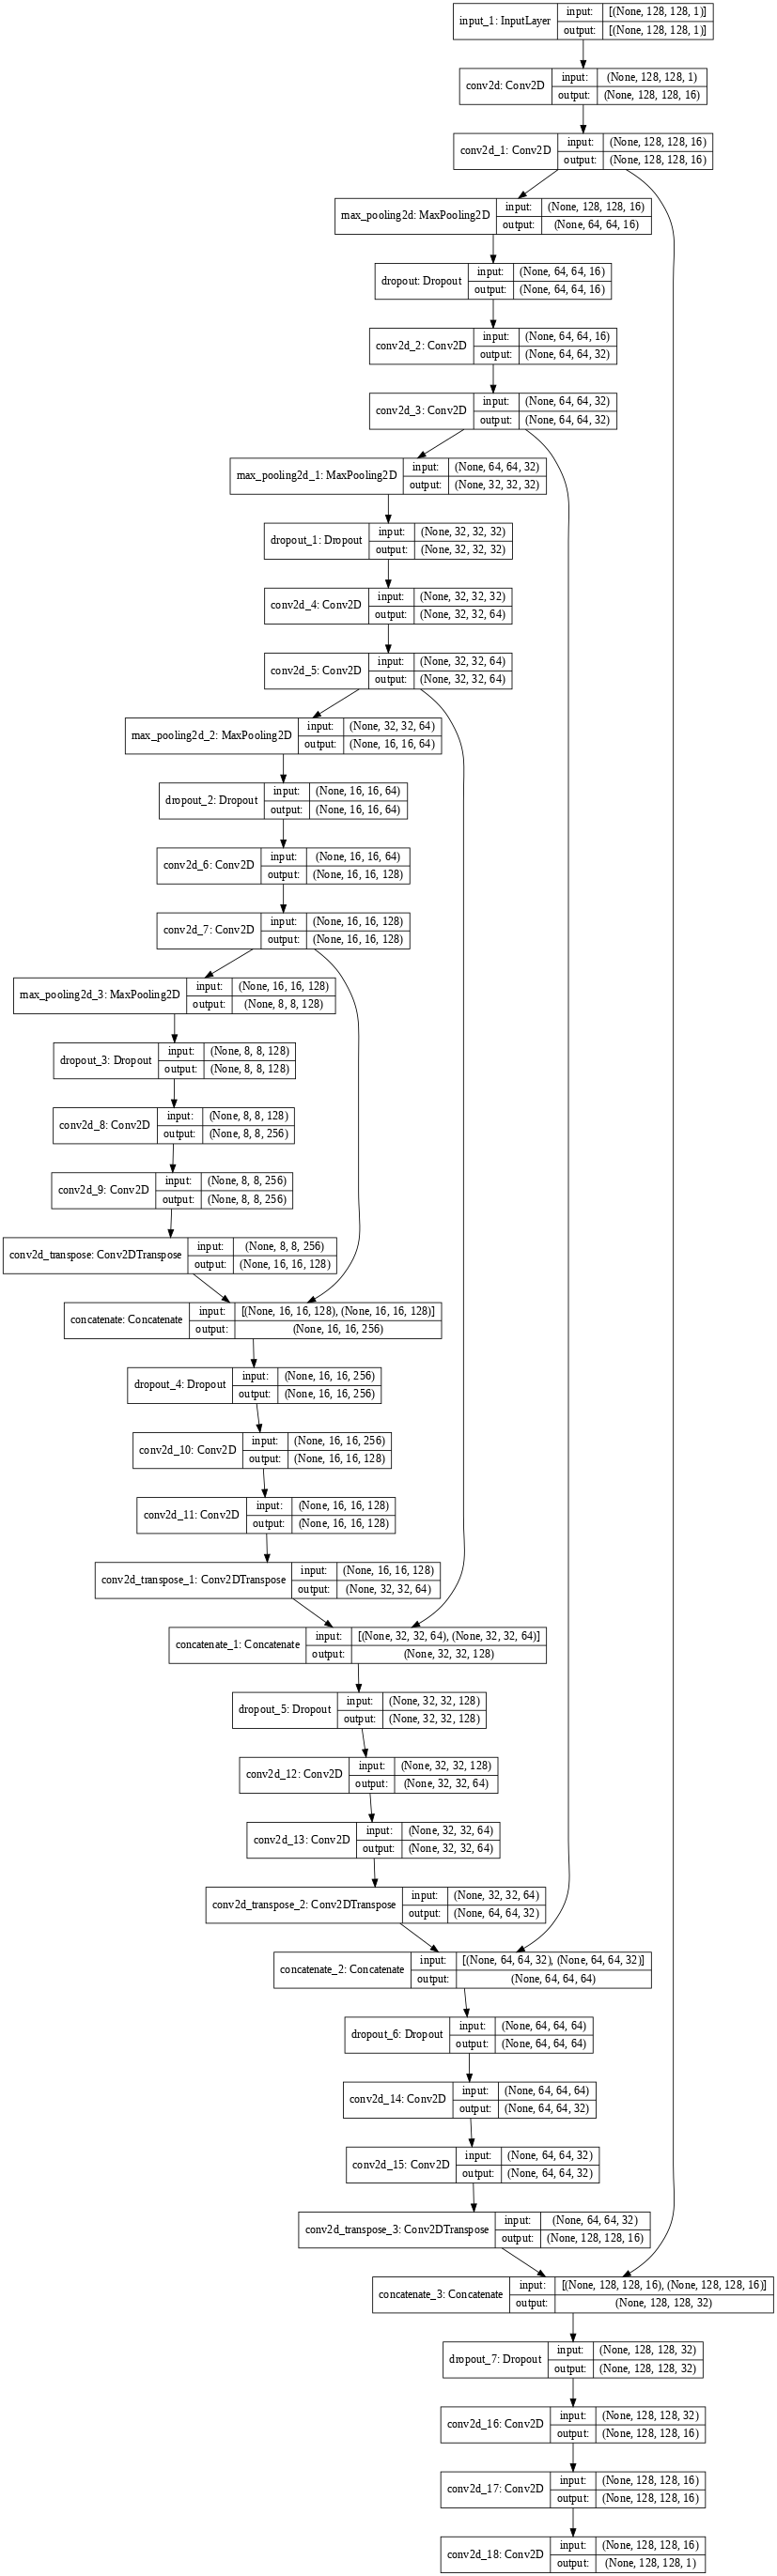

In [12]:
plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)

In [13]:
history = model.fit(lung_train, infect_train, epochs = 20, validation_data = (lung_test, infect_test))

Epoch 1/20
315/315 [==============================] - 34s 80ms/step - loss: 0.2657 - accuracy: 0.9633 - val_loss: 0.0300 - val_accuracy: 0.9927
Epoch 2/20
315/315 [==============================] - 24s 77ms/step - loss: 0.0263 - accuracy: 0.9932 - val_loss: 0.0261 - val_accuracy: 0.9928
Epoch 3/20
315/315 [==============================] - 25s 78ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0226 - val_accuracy: 0.9928
Epoch 4/20
315/315 [==============================] - 25s 81ms/step - loss: 0.0188 - accuracy: 0.9929 - val_loss: 0.0177 - val_accuracy: 0.9927
Epoch 5/20
315/315 [==============================] - 26s 81ms/step - loss: 0.0158 - accuracy: 0.9933 - val_loss: 0.0149 - val_accuracy: 0.9936
Epoch 6/20
315/315 [==============================] - 26s 83ms/step - loss: 0.0148 - accuracy: 0.9935 - val_loss: 0.0133 - val_accuracy: 0.9950
Epoch 7/20
315/315 [==============================] - 26s 83ms/step - loss: 0.0131 - accuracy: 0.9950 - val_loss: 0.0137 - val_accuracy:

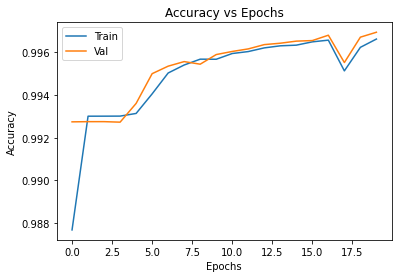

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

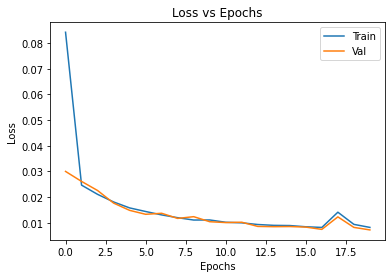

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

Text(0.5, 1.0, 'predicted infection mask')

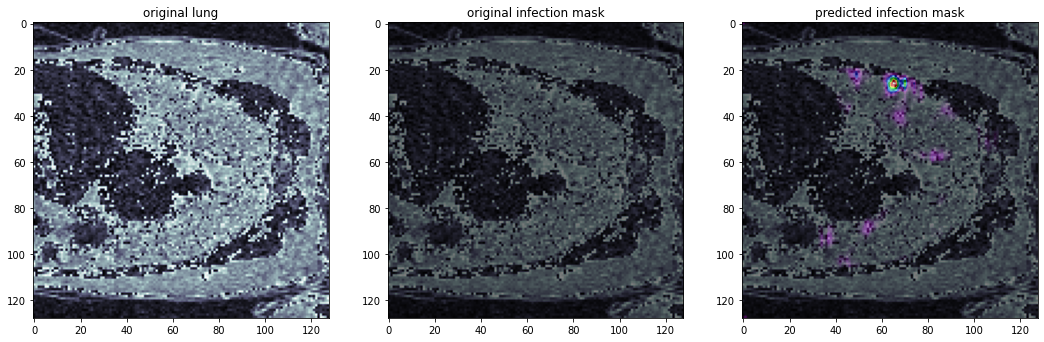

In [16]:
predicted = model.predict(lung_test)
fig = plt.figure(figsize = (18, 15))

plt.subplot(1,3,1)
plt.imshow(lung_test[500][..., 0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
plt.imshow(lung_test[500][..., 0], cmap = 'bone')
plt.imshow(infect_test[500][..., 0], alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(lung_test[500][..., 0], cmap = 'bone')
plt.imshow(predicted[500][..., 0], alpha = 0.5, cmap = "nipy_spectral")
plt.title('predicted infection mask')

In [17]:
import gc
gc.collect()

7200